Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'initial state')

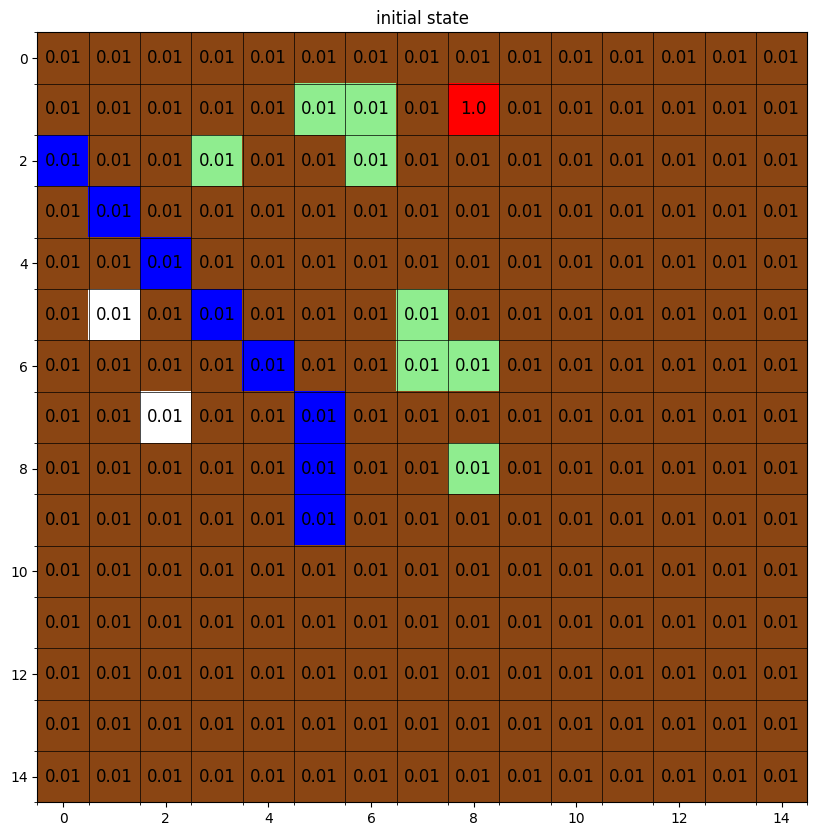

In [300]:
import numpy as np
import matplotlib.pyplot as plt
import random as random 
import math 

def euclidean_distance(cell1, cell2):
    x1, y1 = cell1
    x2, y2 = cell2
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def cell_distance(cell1, cell2):
  rows, cols = GRID_SIZE, GRID_SIZE
  row1, col1 = cell1
  row2, col2 = cell2

  # Handle edge cases (cells outside the grid)
  if not (0 <= row1 < rows and 0 <= col1 < cols and 0 <= row2 < rows and 0 <= col2 < cols):
    return float('inf')  # Or raise an error

  # Calculate row and column differences
  row_diff = abs(row1 - row2)
  col_diff = abs(col1 - col2)

  # Calculate distance (using Chebyshev distance for grid-like movement)
  distance = max(row_diff, col_diff) 
  return distance

# Constants
GRID_SIZE = 15

color_mapping = {
    0 : (0, 0, 0),        # white, burnt square 
    1 : (0, 0, 1),              # Blue, water
    2 : (0.545, 0.271, 0.075),  # Light brown, dead brush 
    3 : (0.564, 0.933, 0.564),  # Light green, live brush 
    4 : (255, 0, 0),            # red, active burn 
    5 : (169, 169, 169)         # grey, structure 
} 

# 1 hour fuel load 
fuel_loads = {
    0 : 0,      # white, burnt square 
    1 : 0,      # Blue, water
    2 : 0.07,   # Light brown, dead brush 
    3 : 0.05,   # Light green, live brush 
    4 : 1.00,      # red, active burn 
    5 : 0.03    # grey, structure 
}

# bed depth 
bed_depth = {
    0 : 0,     # white, burnt square 
    1 : 0,     # Blue, water
    2 : 1,     # Light brown, dead brush 
    3 : 2,     # Light green, live brush 
    4 : 0,     # red, active burn, DO NOT USE THIS VALUE 
    5 : 5      # grey, structure 
}

# Define the grid types
ground_map = np.full((GRID_SIZE, GRID_SIZE), 2) # Default to live brush 

ground_map[2,0] = 1
ground_map[3,1] = 1
ground_map[4,2] = 1
ground_map[5,3] = 1
ground_map[6,4] = 1
ground_map[7,5] = 1
ground_map[8,5] = 1
ground_map[9,5] = 1

ground_map[1,5] = 3
ground_map[1,6] = 3
ground_map[2,6] = 3
ground_map[5,7] = 3
ground_map[6,7] = 3
ground_map[6,8] = 3
ground_map[2,3] = 3
ground_map[8,8] = 3

ground_map[5,1] = 5
ground_map[7,2] = 5

# burn_probabilities = np.zeros((GRID_SIZE, GRID_SIZE))
burn_probabilities = np.full((GRID_SIZE, GRID_SIZE), 0.01)
burn_counters = np.full((GRID_SIZE, GRID_SIZE), -1)
burning_squares = np.full((GRID_SIZE, GRID_SIZE), False, dtype=bool)

burning_squares[1,8] = True

fig, ax = plt.subplots(figsize=(10, 10))

# Create a colored grid
color_grid = np.zeros((GRID_SIZE, GRID_SIZE, 3))
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        color_grid[i, j] = color_mapping[ground_map[i, j]]
        # burn_probabilities[i, j] = fuel_loads[ground_map[i, j]]
        burn_counters[i, j] = bed_depth[ground_map[i, j]]

        if burning_squares[i,j] == True:
            color_grid[i,j] = color_mapping[4]
            burn_probabilities[i,j] = fuel_loads[4]
        
# Plot the grid
ax.imshow(color_grid, interpolation='nearest')

# Add grid lines
ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

# Annotate with the number stored in each grid square
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        ax.text(
            j, i,
            f"{burn_probabilities[i, j]}",
            color="black",
            ha="center", va="center", fontsize=12
        )

plt.title("initial state")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


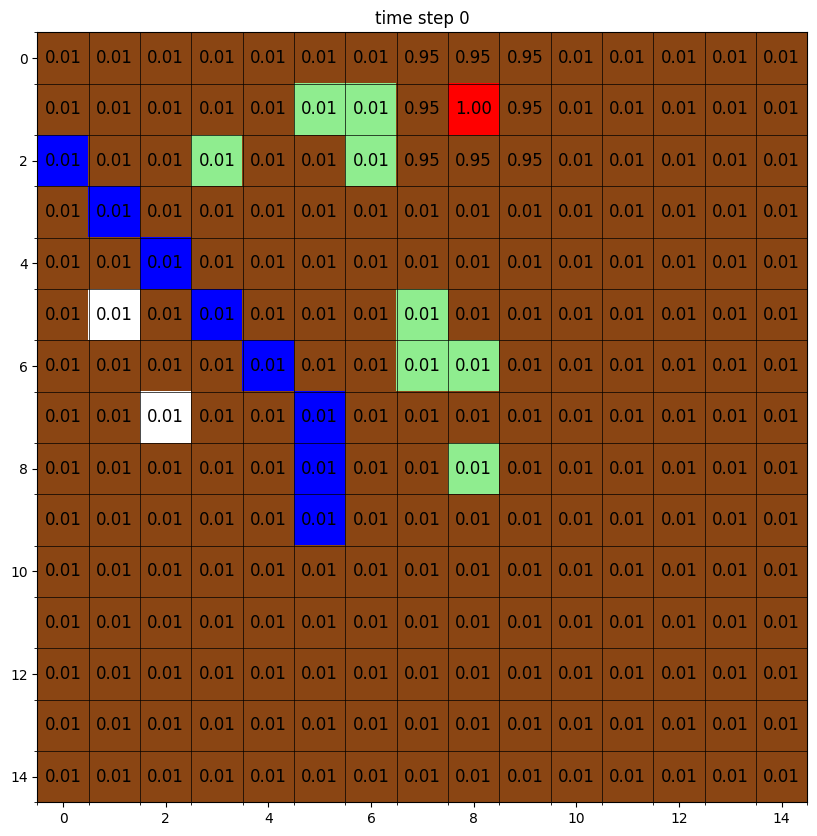

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


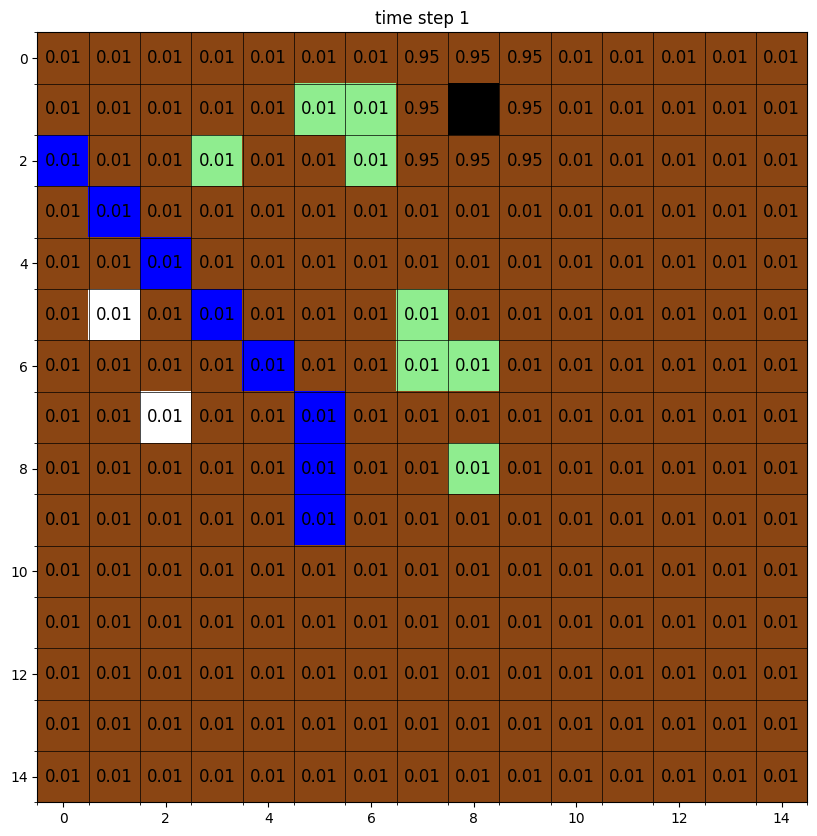

In [301]:
directions = {
    "N": [(-1, 0), (-1, -1), (-1, 1)],
    "E": [(0, 1), (1, 1), (-1, 1)],
    "S": [(1, 0), (1, -1), (1, 1)], 
    "W": [(0, -1), (1, -1), (-1, -1)],

    "SW": [(1, -1), (1, 0), (0, -1)],
    "SE": [(1, 1), (1, 0), (0, 1)],
    "NW": [(-1, -1), (-1, 0), (0, -1)],
    "NE": [(-1, 1), (-1, 0), (0, 1)]
}

adjacents = [(-1,0), (0,1), (1,0), (0,-1), (1,-1), (1,1), (-1,-1), (-1,1)]

# wind speed excess of 15 mph are high risk
# wind speed divided by 10 
WIND_SPEED = 1.5
WIND_DIRECTION = "SW" 

# relative humidity below 15%, or 0.15 is high risk for fire 
# relative humidity multiplied by 10 
HUMIDITY = 1.5

# temperature divided by 10
# above 90 degrees would be high risk 
TEMP = 9

def update_burn_probabilities(ground_map, burn_probabilities, burning_squares, GRID_SIZE):

    # get change in x and y coordinates 
    deltas = directions[WIND_DIRECTION]

    updated_cells = set()

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):

            # if this square is actively burning as of end of last step 
            if burning_squares[i, j]:

                # keep track of all the squares immediately adjacent to it 
                adj_cells = [] 

                # all 8 cells immediately adjacent to the current active burning cell 
                for delta in adjacents: 
                    ni, nj = i + delta[0], j + delta[1]
                    if 0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE:
                        if not burning_squares[ni, nj]: 
                            adj_prob = fuel_loads[ground_map[ni, nj]]

                            # if cell is not nonburnable, water, or actively burning 
                            if ground_map[ni, nj] != 0 and ground_map[ni, nj] != 1 and ground_map[ni, nj] != 4:
                                original_probability = burn_probabilities[ni, nj]

                                distance_to_burn = cell_distance((i,j), (ni,nj))

                                # combination of fuel load, relative humidity, and temperature 
                                new_probability = ((fuel_loads[ground_map[ni,nj]] * TEMP * WIND_SPEED) / distance_to_burn * HUMIDITY) * 0.67

                                # if new_probability > original_probability:
                                burn_probabilities[ni, nj] = new_probability

                                # add this adjacent cell to our list so we can do the second layer 
                                adj_cells.append((ni, nj))

                            # else:
                            #     burn_probabilities[ni, nj] = min(1.0, adj_prob + burn_probabilities[ni, nj])

                for cell in adj_cells: 
                    # go through each adjacent grid square to the burning square 
                    for delta in deltas:
                        # get the coordinates of the adjacent square 
                        ni, nj = cell[0] + delta[0], cell[1] + delta[1]
                        # check if the adjacent square is actually in the bounds of map 
                        if 0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE:
                            # if this square is not currently burning 
                            if not burning_squares[ni, nj] and (ni, nj): 
                                # get its original burn probability 
                                adj_prob = fuel_loads[ground_map[ni, nj]]

                                if ground_map[ni, nj] != 0 and ground_map[ni, nj] != 1 and ground_map[ni, nj] != 4:
                                    burn_probabilities[ni, nj] = 35 * adj_prob 
                                    updated_cells.add((ni, nj))

                                else:
                                    burn_probabilities[ni, nj] = min(1.0, adj_prob + burn_probabilities[ni, nj])
                                    updated_cells.add((ni, nj))

                # decrement its burn counter if it still has time to burn
                if burn_counters[i, j] > 0: 
                    burn_counters[i, j] -= 1 

                # otherwise, take it off the actively burning list 
                else: 
                    burning_squares[i, j] = False 
                    ground_map[i, j] = 0
                    color_grid[i, j] = color_mapping[ground_map[i, j]]

            # if ground_map[i, j] != 0 and ground_map[i, j] != 1 and ground_map[i, j] != 4:
            #     random_number = random.random()
            #     if random_number < burn_probabilities[i, j]: 
            #         burning_squares[i, j] = True 
            #         ground_map[i, j] = 4
            #         color_grid[i, j] = color_mapping[ground_map[i, j]]
            #         burn_probabilities[i, j] = 1

for step in range(2):
    update_burn_probabilities(ground_map, burn_probabilities, burning_squares, GRID_SIZE)

    # Plot the updated grid
    fig, ax = plt.subplots(figsize=(10, 10))

    # color_grid = np.zeros((GRID_SIZE, GRID_SIZE, 3))
    
    # for i in range(GRID_SIZE):
    #     for j in range(GRID_SIZE):
    #         color_grid[i, j] = color_mapping[ground_map[i, j]]
    #         if burning_squares[i, j]:
    #             color_grid[i, j] = color_mapping[4]

    ax.imshow(color_grid, interpolation='nearest')

    # Add grid lines
    ax.set_xticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, GRID_SIZE, 1), minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

    # Annotate with the number stored in each grid square
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax.text(
                j, i,
                f"{burn_probabilities[i, j]:.2f}",
                color="black",
                ha="center", va="center", fontsize=12
            )

    plt.title(f'time step {step}')
    plt.show()

            